# Symplectic explicit integrators in OrdinaryDiffEq

## Loading packages and functions

In [1]:
using LinearAlgebra
using Plots
using OrdinaryDiffEq


In [2]:
function copysol2ndNbody(u0,sol,prob,alg)
   #    
   #   return a copy of sol, converting sol.u to original u0's format 
   #
   #    
       n=length(sol.u)
       ttype=eltype(sol.t)
       uu=Vector{typeof(u0)}(undef,n)
       tt=Vector{ttype}(undef,n)
       uk=copy(u0)
   
       for k in 1:n
            uk[:,:,1]=sol.u[k].x[2]
            uk[:,:,2]=sol.u[k].x[1]
            uu[k]=copy(uk)
            tt[k]=sol.t[k]
       end
   
       sol_new=DiffEqBase.build_solution(prob, alg, tt, uu, stats=sol.stats, retcode=sol.retcode)

       return sol_new
           
   end

copysol2ndNbody (generic function with 1 method)

##### <a href="#top">Back to the top</a>

## Definition of the N-body problem

In Nbody.jl below, the following functions are defined: NbodyEnergy(u,Gm), NbodyODE!(du,u,Gm,t), and NbodyODE1!(du,u,Gm,t), where

\begin{equation*}
u = 
\left(\begin{matrix}
q_1  & v_1\\
\vdots & \vdots \\
q_N  & v_N
\end{matrix}
\right) \in \mathbb{R}^{2 \times 3\times N}, \quad
Gm = (G\,  m_1, \ldots,G\,  m_N) \in \mathbb{R}^N.
\end{equation*}

The energy, as a function of the positions $q_1,\ldots,q_N \in \mathbb{R}^3$ and the velocities $v_1,\ldots,v_N \in \mathbb{R}^3$ of the $N$ bodies is:
\begin{equation*}
\begin{split}
\mathrm{Energy}(q_1,\ldots,q_N,v_1,\ldots,v_N) = 
\frac12 \sum_{i=1}^{N} m_i \, \|v_i\|^2
- G \sum_{1\leq i < j \leq N} \frac{m_i m_j}{\|q_i-q_j\|}.
\end{split}
\end{equation*}


The ODE system of the N-body problem,
as a function of the positions $q_1,\ldots,q_N \in \mathbb{R}^3$ and the velocities $v_1,\ldots,v_N \in \mathbb{R}^3$ of the $N$ bodies is:
\begin{equation*}
\begin{split}
\frac{d}{dt} q_i &= v_i, \\
\frac{d}{dt} v_i &= G\, 
\sum_{j \neq i} \frac{m_j}{\|q_j-q_i\|^3}\,
(q_j-q_i).
\end{split}
\end{equation*}
This system of ODEs can be writen in compact form as
\begin{equation*}
\frac{d u}{dt} = f(t,u,Gm)
\end{equation*}

In [16]:
PATH_IRKGL="../../../../IRKGaussLegendre.jl-master/IRKGaussLegendre.jl-master/"
PATH_ODES=string(PATH_IRKGL,"ODEProblems/")

include(string(PATH_ODES,"Initial6Body.jl"))
include(string(PATH_ODES,"Nbody.jl"))
include(string(PATH_ODES,"Nbody2nd.jl"))

NbodyODE2nd! (generic function with 1 method)

### Initial value problem: 6-body problem (outer solar system)

We consider $N=6$ bodies of the outer solar system: the Sun, Jupiter, Saturn, Uranus, Neptune and Pluto.
The initial values $u_{00}$ are taken from DE430, Julian day (TDB) 2440400.5 (June 28, 1969). 

In [17]:
u0, Gm, bodylist = Initial6Body(Float64)
#u0_B, Gm_B, bodylist = Initial6Body(BigFloat)
u0_B=BigFloat.(u0)
Gm_B=BigFloat.(Gm)

q0=u0[:,:,1]
v0=u0[:,:,2]

N = length(Gm)

show(bodylist)
E0=NbodyEnergy(u0,Gm)

["Sun" "Jupiter" "Saturn" "Uranus" "Neptune" "Pluto"]

-9.522620605966966e-12

In [18]:
# Testing: center of mass of the outer solar system at the origin of coordinates with zero velocity

q0_ = zeros(3)
v0_ = zeros(3)
Gm0_ = 0.
for i in 1:6
    Gmi = Gm[i]
    qi = u0[:,i,1]
    vi = u0[:,i,2]
    q0_ += Gmi*qi
    v0_ += Gmi*vi
    Gm0_ += Gmi
end
(q0_/Gm0_, v0_/Gm0_)

([1.417048569677335e-18, 9.119357686204585e-20, 1.5082339679877506e-19], [1.0942040830907497e-22, -2.709864045560887e-22, 1.6237832716049163e-22])

In [19]:
t0=0.
tF=1e8   #1e9  # days

tspan= (t0,tF)
tspan_B=(BigFloat(t0),BigFloat(tF))

prob = ODEProblem(NbodyODE!, u0,tspan , Gm)
prob2nd = SecondOrderODEProblem(NbodyODE2nd!,v0,q0,(t0,tF),Gm);

In [20]:
Jupiter_period = 11.9*365
tF/Jupiter_period

23022.90779325429

In [21]:
year=365.25
tF/year

273785.0787132101

## Integrations

In [22]:
dt0=20.

dt1=18*dt0

alg=SofSpa10()
@time sol1=solve(prob2nd,alg,dt=dt1, saveat=dt1*10, adaptive=false)
sol1_=copysol2ndNbody(u0,sol1,prob2nd,alg)

sol1.retcode
length(sol1.t)

  3.535263 seconds (7.95 M allocations: 497.007 MiB, 5.08% gc time, 74.86% compilation time)


27779

In [23]:
alg=VelocityVerlet()
@time sol2=solve(prob2nd,alg,dt=dt0, saveat=dt0*100, adaptive=false)
sol2_=copysol2ndNbody(u0,sol2,prob2nd,alg)

sol2.retcode

  2.102464 seconds (2.95 M allocations: 207.217 MiB, 12.14% gc time, 58.25% compilation time)


ReturnCode.Success = 1

In [24]:
alg=VerletLeapfrog()
@time sol3=solve(prob2nd,alg,dt=dt0, saveat=dt0*100, adaptive=false)
sol3_=copysol2ndNbody(u0,sol3,prob2nd,alg)

sol3.retcode

  2.960004 seconds (2.83 M allocations: 198.540 MiB, 8.28% gc time, 41.56% compilation time)


ReturnCode.Success = 1

<a href="#top">Back to the top</a>

## Errors in energy

In [25]:
function ErrorEnergy(H0, Ham, sol, parms_B)

    H = [Ham(BigFloat.(u),parms_B) for u in sol.u]
    ΔH0 = @. Float64(abs(H/H0-1))
    H_lerr = @. Float64(abs((H[2:end] / H[1:end-1]) - 1))
   
    return ΔH0, H_lerr

end

ErrorEnergy (generic function with 1 method)

In [26]:
u0_B = BigFloat.(u0)
Gm_B = BigFloat.(Gm)
H0=NbodyEnergy(u0_B,Gm_B)

ΔH0_1, H_lerr_1=ErrorEnergy(H0, NbodyEnergy, sol1_, Gm_B)
ΔH0_2, H_lerr_2=ErrorEnergy(H0, NbodyEnergy, sol2_, Gm_B)
ΔH0_3, H_lerr_3=ErrorEnergy(H0, NbodyEnergy, sol3_, Gm_B)
(maximum(ΔH0_1), maximum(H_lerr_1), maximum(ΔH0_2), maximum(H_lerr_2),  maximum(ΔH0_3), maximum(H_lerr_3))

(1.722267648590549e-11, 1.3199907794471085e-11, 3.9075508721742704e-5, 4.135275742963417e-5, 3.907550860846496e-5, 4.135275741905887e-5)

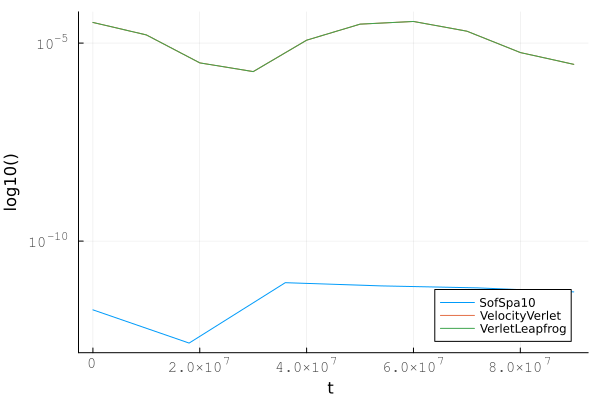

In [27]:
yrange=(1e-20,1e-10)
m0 = max(1,div(Int64(ceil((tF-t0)/dt0)),1000)) 
plot(title="",xlabel="t ", ylabel="log10()", 
     yscale=:log10, 
     #ylims=yrange,
     xtickfont = font(8, "Courier"),
     ytickfont = font(8, "Courier"),
     legend=:bottomright)
plot!(sol1_.t[2:m0:end],abs.(ΔH0_1[2:m0:end]),label="SofSpa10")
plot!(sol2_.t[2:m0:end],abs.(ΔH0_2[2:m0:end]),label="VelocityVerlet")
plot!(sol3_.t[2:m0:end],abs.(ΔH0_3[2:m0:end]),label="VerletLeapfrog")